<a href="https://colab.research.google.com/github/Pratichhya/ubs_course/blob/main/Sharma_MM_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inundation Extent based on Mathematical Morphology

Inundation is result from flood and tsunami and several human activities like making dams. L-band of SAR image is used as it can help in easy detection of water surface.
Here I have tried in implementing a small portion of the workflow adopted in the paper "Estimation of Inudation Extent Based on Mathematical Morphology" that involves mathematical morphology basic operations. 



In [ ]:
!pip install rasterio

In [ ]:
#Importing necesary data pacakages
import rasterio 
from rasterio import plot
from scipy import ndimage #for greyscale image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat) #for binary image
from skimage.morphology import square
from skimage.filters import try_all_threshold

SAR dataset has been used after pre-processing it in GEE. MSI was avoided here because of large cloud cover in the image during the season of flood.

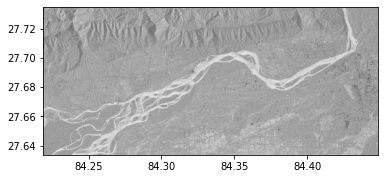

In [ ]:
# Reading data
dataset = rasterio.open('/content/drive/MyDrive/ubs/image processing/SAR_sharma.tif')
plot.show(dataset,cmap='gray_r')

## 1. Basic Steps
To determine the extent of inundation, I used Dilation followed by Opening on both Binary and Grey-Scale images in the following steps. Out of curiosity, I have used both binary and gray-scale images here, but in the paper, only one type of image was used. 

In [ ]:
#for parallel comparision of the plots
def plot_comparison(original, computed, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), sharex=True,sharey=True)
    #plot for original
    ax1.imshow(original, cmap=plt.cm.gray_r)
    ax1.set_title('original')
    ax1.axis('off')
    #plot for computed
    ax2.imshow(computed, cmap=plt.cm.gray_r)
    ax2.set_title(filter_name)
    ax2.axis('off')

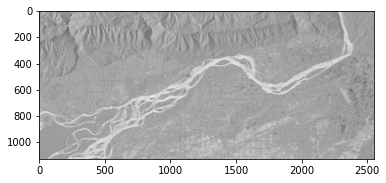

255


(1127, 2554)

In [ ]:
#conversion into greyscale image
a=dataset.read()
img=(a/np.max((a))*255).astype(int)
img=img.reshape(1127,2554*1)
plot.show(img,cmap='gray_r')
print(np.max((img)))
img.shape

The light elongated lines in the plot above represent the river network

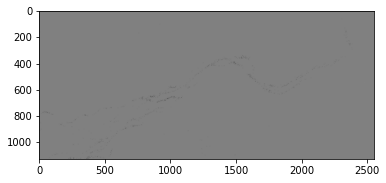

1


In [ ]:
#conversion into binary image
b=dataset.read()
img_b=(b/np.max((b))).astype(int)
img_b=img_b.reshape(1127,2554*1)
plot.show(img_b,cmap='gray')
print(np.max((img_b)))

A very faint river network can be seen in the binary image above. As previously stated, the sole purpose of using binary images is to comprehend the methodology in binary method.

##2. Morphological Dilation
(Expansion Operation 2 times at 3x3 size): Water invasion extent corresponding to water body extent can be estimated by expansion operation.
Based on internet search 3x3 size square structural element was used for the dilation purpose.

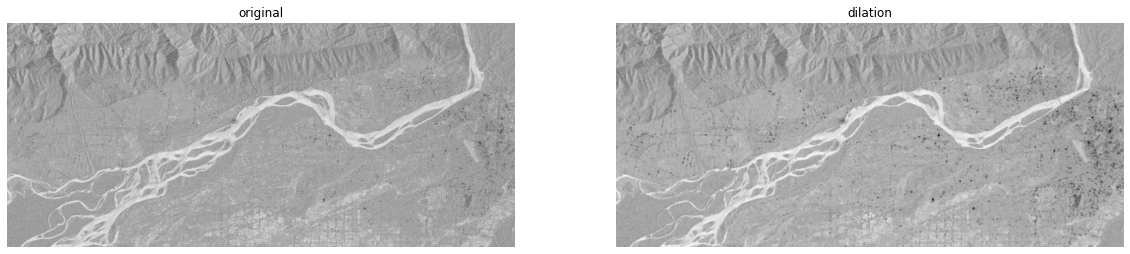

In [ ]:
dil_img=ndimage.grey_dilation(img, size=(5,5))
#dil2_img=ndimage.grey_dilation(dil_img, size=(2,2))
plot_comparison(img, dil_img, 'dilation')

This method made objects more visible by filling in small holes previously existed

(-0.5, 2553.5, 1126.5, -0.5)

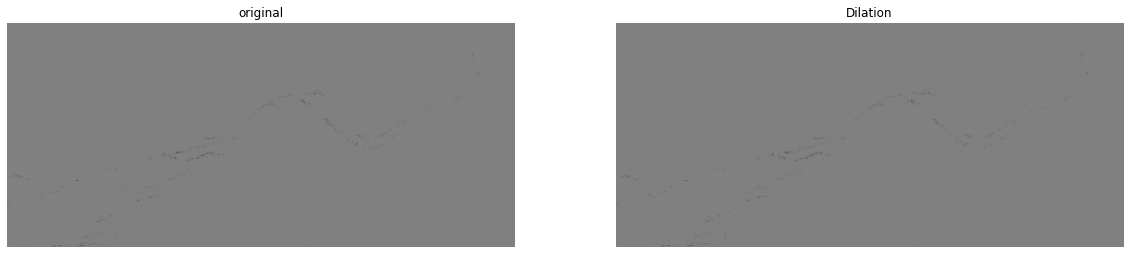

In [ ]:
#binary dilation
dil_b = dilation(img_b, square(1))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), sharex=True,sharey=True)
ax1.imshow(img_b, cmap=plt.cm.gray)
ax1.set_title('original')
ax1.axis('off')
ax2.imshow(dil_b, cmap=plt.cm.gray)
ax2.set_title("Dilation")
ax2.axis('off')

##3. Morphological Opening Operation
The opening operation in the water invasion extent is used to remove unnecessary structuring elements and smooth the outline of the extent (with  SE of 12x12). This step is also useful for removing small unnecessary polygons.

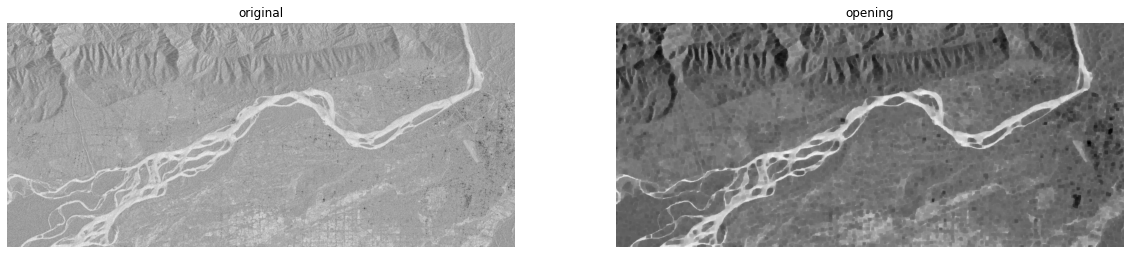

In [ ]:
#greyscale opening operation
open_img=ndimage.grey_opening(dil_img, size=(12,12))
plot_comparison(img,open_img, 'opening')

Opening helped the objects to retain their original shape by removing singke-pixel objects.

<function rasterio.plot.show>

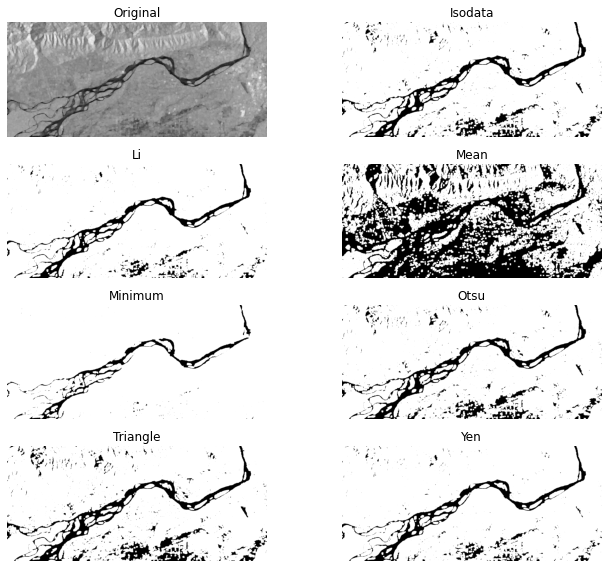

In [ ]:
#simple way to get water-extent of particular threshold
#filtered= np.where(open_img<-170,0,1)
#plot.show(filtered, cmap="gray").set_title("Inundation Extent")

#identifying the best model for determining threshold extent
fig, ax=try_all_threshold(open_img,figsize=(10,8),verbose=False)
plot.show

Based on the plot above, we can conclude that the minimum threshold model produced the best results. As a result, the minimum threshold method was used to determine the final inundation extent.

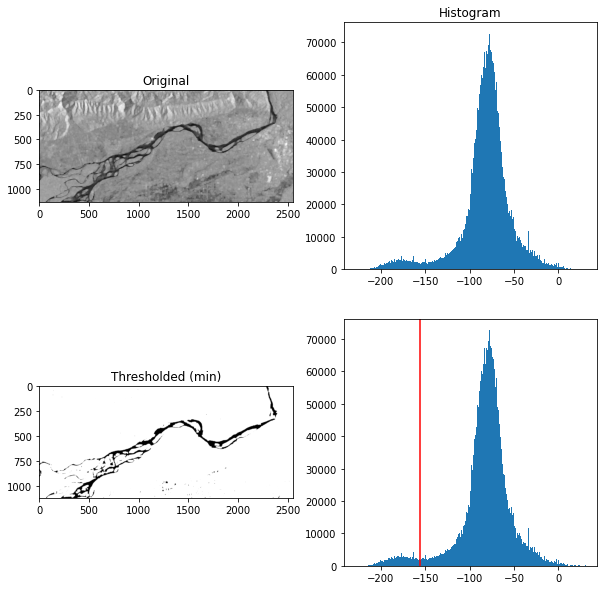

In [ ]:
from skimage.filters import threshold_minimum

#compare the minimum threshold
thresh_min = threshold_minimum(open_img)
greyscale_min = open_img > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#plotting original image corresponding to its threshold
ax[0, 0].imshow(open_img, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')
#for histogram
ax[0, 1].hist(open_img.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

#plotting extent to minimum threshold
ax[1, 0].imshow(greyscale_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')
#for histogram of minimum threshold
ax[1, 1].hist(open_img.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

plt.show()

(-0.5, 2553.5, 1126.5, -0.5)

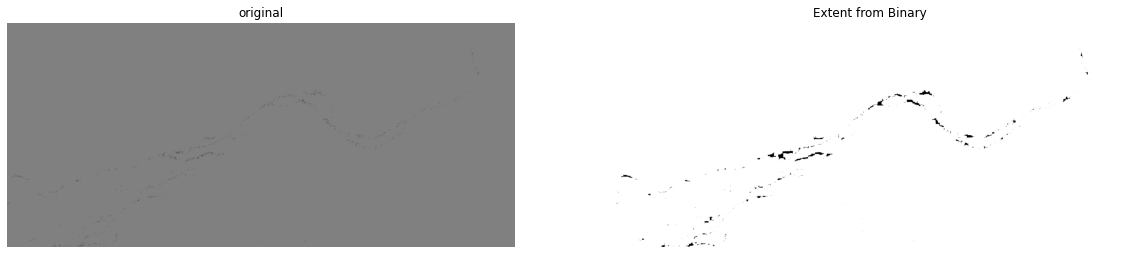

In [ ]:
#binary opening
open_b = opening(dil_b, square(12))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), sharex=True,sharey=True)
ax1.imshow(img_b, cmap=plt.cm.gray)
ax1.set_title('original')
ax1.axis('off')
ax2.imshow(open_b, cmap=plt.cm.gray)
ax2.set_title("Extent from Binary")
ax2.axis('off')

Although similar steps were taken, the binary image yielded very poor results, implying that grey-scale images are a better choice for this type of analysis.

## Pros and Cons of the methodology adopted in this paper
Use of Mathematical Morphology is of great benefit as also mentioned and discussed in this paper.

Pros:
* Calculation was easily and obtained very swiftly.
* The results obtained can be further utilized by decision makers in case of evacuation and disaster response activities

Cons:
* The paper didn't mention clearly on the type of data used other than DEM. It refered to use of RS data that made me more confused on the type of data it was refering to. 





                                                      Thank you

